In [1]:
import numpy as np
import deepdish as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import gc
from sklearn.preprocessing import RobustScaler

In [2]:
n_inds = 30
bayes_sample = 5000

fps = 10
scale = "07"
folders = ['ffABC1']

In [3]:
for i,name in enumerate(folders):
    tmp = pd.read_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/pigeons/' + str(n_inds) + '_birds/' + name + '/' + 'pairwise_' + scale + '.csv')
    tmp2 = pd.read_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/pigeons/' + str(n_inds) + '_birds/' + name + '/' + 'individual_' + scale + '.csv')
    tmp['vid_id'] = i
    tmp2['vid_id'] = i
    
    pair_drops = ['Unnamed: 0', 'tau']
    ind_drops = ['Unnamed: 0', 'rx', 'ry', 'lscore', 'lfinal']
    tmp.drop(pair_drops, axis=1, inplace=True)
    tmp2.drop(ind_drops, axis=1, inplace=True)
    
    if i != 0:
        pair1 = np.concatenate((pair1,tmp), axis=0)
        ind1 = np.concatenate((ind1,tmp2), axis=0)
    else:
        pair1 = tmp
        ind1 = tmp2
        cols = list(tmp)
        col_ind = list(tmp2)
        
pair1 = pd.DataFrame(pair1)
pair1.columns = cols

ind1 = pd.DataFrame(ind1)
ind1.columns = col_ind

In [4]:
n_inds = 10
folders = ['ffA3', 'ffA4', 'ffB3', 'ffB4', 'ffC3', 'ffC4']

In [5]:
for i,name in enumerate(folders):
    tmp = pd.read_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/pigeons/' + str(n_inds) + '_birds/' + name + '/' + 'pairwise_' + scale + '.csv')
    tmp2 = pd.read_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/pigeons/' + str(n_inds) + '_birds/' + name + '/' + 'individual_' + scale + '.csv')
    tmp['vid_id'] = i+1
    tmp2['vid_id'] = i+1
    
    pair_drops = ['Unnamed: 0', 'tau']
    ind_drops = ['Unnamed: 0', 'rx', 'ry', 'lscore', 'lfinal']
    tmp.drop(pair_drops, axis=1, inplace=True)
    tmp2.drop(ind_drops, axis=1, inplace=True)
    
    if i != 0:
        pair2 = np.concatenate((pair2,tmp), axis=0)
        ind2 = np.concatenate((ind2,tmp2), axis=0)
    else:
        pair2 = tmp
        ind2 = tmp2
        cols = list(tmp)
        col_ind = list(tmp2)
        
pair2 = pd.DataFrame(pair2)
pair2.columns = cols

ind2 = pd.DataFrame(ind2)
ind2.columns = col_ind

In [6]:
pairs = pd.concat([pair1,pair2], axis=0, sort=True)
inds = pd.concat([ind1,ind2], axis=0, sort=True)

In [7]:
del tmp
del tmp2
del pair1
del pair2
del ind1
del ind2

gc.collect()

110

In [8]:
df = pd.merge(pairs, inds)

del pairs
del inds

gc.collect()

35

In [9]:
scaler = RobustScaler()
scaled = scaler.fit_transform(df[['ang_pos', 'dist', 'speed_diff', 'acc_diff', 'speed', 'acceleration']].values)

cols = ['ang_pos', 'dist', 'speed_diff', 'acc_diff', 'speed', 'acceleration']
df = df.drop(cols, axis=1)

for idx, col in enumerate(['ang_pos_scaled', 'dist_scaled', 'speed_diff_scaled', 'acc_diff_scaled', 'speed_scaled', 'acceleration_scaled']):
    df[col] = scaled[:, idx]
    
df.head()

,#t(centisec),cc,f_id,n_id,vid_id,dev_gacc,dev_gspeed,ang_pos_scaled,dist_scaled,speed_diff_scaled,acc_diff_scaled,speed_scaled,acceleration_scaled
0,35.0,0.0,0.0,1.0,0.0,0.822576,-0.466144,-0.085426,0.504605,1.738051,-0.476137,-0.005515,0.526142
1,35.0,0.0,0.0,2.0,0.0,0.822576,-0.466144,-0.712271,0.263719,0.834195,-0.550252,-0.005515,0.526142
2,35.0,1.0,0.0,3.0,0.0,0.822576,-0.466144,-0.473042,1.151804,2.550128,-0.043349,-0.005515,0.526142
3,35.0,0.0,0.0,4.0,0.0,0.822576,-0.466144,-0.474788,0.937747,0.808754,0.250558,-0.005515,0.526142
4,35.0,0.0,0.0,5.0,0.0,0.822576,-0.466144,-0.825394,-0.206240,0.051655,-1.666547,-0.005515,0.526142


In [10]:
df['cc'] = df['cc'].astype(np.int8)

df = df.dropna()

### Run a bayesian model to predict leadership

In [11]:
bayes_df0 = df[df['cc'] == 0].sample(n = bayes_sample//2)
bayes_df1 = df[df['cc'] == 1].sample(n = bayes_sample//2)
bayes_df = pd.concat((bayes_df0, bayes_df1), axis=0)
bayes_df = bayes_df.sample(frac=1).reset_index(drop=True)

del bayes_df0
del bayes_df1

In [12]:
# Save the dataframe
bayes_df.to_csv('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Data/Output/pigeons/bayes_df_s' + scale + '.csv', mode='w')

#### a) from a neural representation

In [12]:
mod = """
data {
    int<lower=0> n;
    int cc[n];
    real dist[n];
    real apos[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    for(i in 1:n) {
        cc[i] ~ bernoulli(inv_logit(a + b*dist[i] + c*apos[i]));
    }
}
generated quantities {
    int cc_pred[n];
    for(i in 1:n) {
        cc_pred[i] = bernoulli_rng(inv_logit(a + b*dist[i] + c*apos[i]));
    }
}
"""

data = {
        'n': len(bayes_df),
        'cc': bayes_df.cc,
        'dist': bayes_df.dist_scaled,
        'apos': bayes_df.ang_pos_scaled,
        }

neural_model = pystan.StanModel(model_code=mod, model_name='scale_' + scale)
# dd.io.save('Data/Output/pigeons/' + str(n_inds) + '_birds/nmod_s' + scale + '.h5', neural_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL scale_07_8252edb6095465b836890d0a76837b20 NOW.


In [13]:
neural_fit = neural_model.sampling(data=data, chains=4, iter=2000, control = dict(max_treedepth=15))
# dd.io.save('Data/Output/pigeons/' + str(n_inds) + '_birds/nfit_s' + scale + '.h5', neural_fit)

0.523 0.5366 0.5502


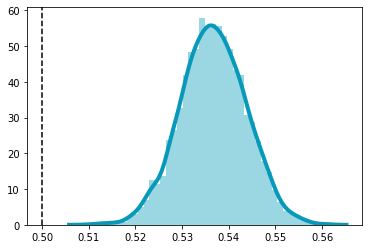

In [14]:
acc_n = np.sum(neural_fit['cc_pred'] == np.array(bayes_df['cc']), axis=1) / len(bayes_df)
print(np.quantile(acc_n, 0.025), np.median(acc_n), np.quantile(acc_n, 0.975))

ax = sns.distplot(acc_n, hist=True, kde=True, color = '#0799b9', kde_kws={'linewidth': 4})
plt.axvline(x=0.5, color='black', linestyle='dashed')

#### b) from kinematics

In [15]:
mod = """
data {
    int<lower=0> n;
    int cc[n];
    real speed[n];
    real acc[n];
    real sdiff[n];
    real adiff[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
    real d;
    real e;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    d ~ normal(0, 10);
    e ~ normal(0, 10);
    
    for(i in 1:n) {
        cc[i] ~ bernoulli(inv_logit(a + b*speed[i] + c*acc[i] + d*sdiff[i] + e*adiff[i]));
    }
}
generated quantities {
    int cc_pred[n];
    for(i in 1:n) {
        cc_pred[i] = bernoulli_rng(inv_logit(a + b*speed[i] + c*acc[i] + d*sdiff[i] + e*adiff[i]));
    }
}
"""

data = {
        'n': len(bayes_df),
        'cc': bayes_df.cc,
        'speed': bayes_df.speed_scaled,
        'acc': bayes_df.acceleration_scaled,
        'sdiff': bayes_df.speed_diff_scaled,
        'adiff': bayes_df.acc_diff_scaled,
        }

k_model = pystan.StanModel(model_code=mod, model_name='scale_' + scale)
# dd.io.save('Data/Output/pigeons/' + str(n_inds) + '_birds/kmod_s' + scale + '.h5', k_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL scale_07_4bce8efd1e6da14169ef2ea58b606909 NOW.


In [16]:
k_fit = k_model.sampling(data=data, chains=4, iter=2000, control = dict(max_treedepth=15))
# dd.io.save('Data/Output/pigeons/' + str(n_inds) + '_birds/kfit_s' + scale + '.h5', k_fit)

0.5016 0.516 0.5298


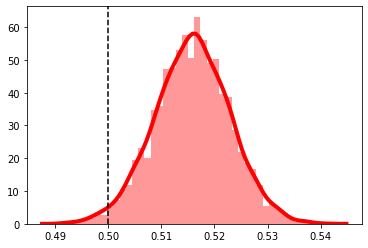

In [18]:
acc_k = np.sum(k_fit['cc_pred'] == np.array(bayes_df['cc']), axis=1) / len(bayes_df)
print(np.quantile(acc_k, 0.025), np.median(acc_k), np.quantile(acc_k, 0.975))

sns.distplot(acc_k, hist=True, kde=True, color = '#ff0000', kde_kws={'linewidth': 4})
plt.axvline(x=0.5, color='black', linestyle='dashed')

#### c) from a neural representation + kinematics

In [19]:
mod = """
data {
    int<lower=0> n;
    int cc[n];
    real dist[n];
    real apos[n];
    real speed_med[n];
    real acc_med[n];
    real sdiff_med[n];
    real adiff_med[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
    real d;
    real e;
    real f;
    real g;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    d ~ normal(0, 10);
    e ~ normal(0, 10);
    f ~ normal(0, 10);
    g ~ normal(0, 10);
    
    for(i in 1:n) {
        cc[i] ~ bernoulli(inv_logit(a + b*dist[i] + c*apos[i] + d*speed_med[i] + e*acc_med[i] + f*sdiff_med[i] + g*adiff_med[i]));
    }
}
generated quantities {
    int cc_pred[n];
    for(i in 1:n) {
        cc_pred[i] = bernoulli_rng(inv_logit(a + b*dist[i] + c*apos[i]  + d*speed_med[i] + e*acc_med[i] + f*sdiff_med[i] + g*adiff_med[i]));
    }
}
"""

data = {
        'n': len(bayes_df),
        'cc': bayes_df.cc,
        'dist': bayes_df.dist_scaled,
        'apos': bayes_df.ang_pos_scaled,
        'speed_med': bayes_df.speed_scaled,
        'acc_med': bayes_df.acceleration_scaled,
        'sdiff_med': bayes_df.speed_diff_scaled,
        'adiff_med': bayes_df.acc_diff_scaled,
        }

nk_model = pystan.StanModel(model_code=mod, model_name='scale_' + scale)
# dd.io.save('Data/Output/pigeons/' + str(n_inds) + '_birds/nkmod_s' + scale + '.h5', nk_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL scale_07_4f8cfce39ff1ae96ff5d86dc84f3f976 NOW.


KeyboardInterrupt: 

In [20]:
nk_fit = nk_model.sampling(data=data, chains=4, iter=2000, control = dict(max_treedepth=15))
# dd.io.save('Data/Output/pigeons/' + str(n_inds) + '_birds/nkfit_s' + scale + '.h5', nk_fit)

0.6193949999999999 0.6326 0.645605


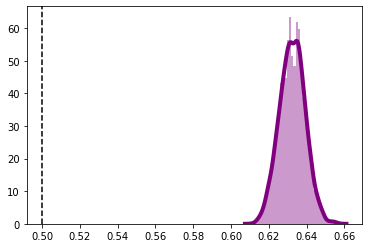

In [21]:
acc_nk = np.sum(nk_fit['cc_pred'] == np.array(bayes_df['cc']), axis=1) / len(bayes_df)
print(np.quantile(acc_nk, 0.025), np.median(acc_nk), np.quantile(acc_nk, 0.975))

sns.distplot(acc_nk, hist=True, kde=True, color = '#800080', kde_kws={'linewidth': 4})
plt.axvline(x=0.5, color='black', linestyle='dashed')

### Accuracies over all models

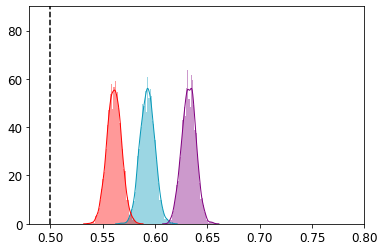

In [22]:
sns.distplot(acc_n, label='relative position (M1)', color='#0799b9', hist=True, kde=True, kde_kws={'linewidth': 1})
sns.distplot(acc_k, label='kinematics (M2)', color='#ff0000', hist=True, kde=True, kde_kws={'linewidth': 1})
sns.distplot(acc_nk, label='M1+M2', color='#800080', hist=True, kde=True, kde_kws={'linewidth': 1})

plt.axvline(x=0.5, color='black', linestyle='dashed')
# plt.legend(loc=1, prop={'size' : 14}, frameon=False) # bbox_to_anchor=(1.03, 1.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0.48,0.80)
plt.yticks([0,20,40,60,80])
plt.ylim(0,90)
plt.savefig('/home/user/Documents/Vivek/cuda/DirectionalCorrelation/Figures/pigeons/accuracies_s' + scale + '_mod.png', format='png', dpi=600, bbox_inches="tight")